In [1]:
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np

import tszip

import nb_utils

In [2]:
data_dir = Path("../data")

In [3]:
ts_file = data_dir / "sc2ts_viridian_v1.2.trees.tsz"
ts = tszip.decompress(ts_file)

In [4]:
recomb_file = data_dir / "recombinants.csv"
recomb_df = pd.read_csv(recomb_file)
recomb_df.columns

Index(['recombinant', 'sample_id', 'num_descendant_samples', 'num_samples',
       'distinct_sample_pango', 'interval_left', 'interval_right',
       'num_mutations', 'Viridian_amplicon_scheme', 'Artic_primer_version',
       'date_added', 'group_id', 'group_size', 'recombinant_pango',
       'recombinant_scorpio', 'recombinant_time', 'recombinant_date', 'sample',
       'sample_pango', 'sample_scorpio', 'sample_time', 'sample_date',
       'parent_left', 'parent_left_pango', 'parent_left_scorpio',
       'parent_left_time', 'parent_left_date', 'parent_right',
       'parent_right_pango', 'parent_right_scorpio', 'parent_right_time',
       'parent_right_date', 'oldest_child', 'oldest_child_pango',
       'oldest_child_scorpio', 'oldest_child_time', 'oldest_child_date',
       'parent_mrca', 'parent_mrca_pango', 'parent_mrca_scorpio',
       'parent_mrca_time', 'parent_mrca_date', 'is_rebar_recombinant',
       'parent_pangonet_distance', 'net_min_supporting_loci_lft',
       'net_min_s

In [5]:
print(f"Total: {len(recomb_df)}")
print(f"Pass: {sum(recomb_df.net_min_supporting_loci_lft_rgt_ge_4)}")
print(f"Fail: {sum(~recomb_df.net_min_supporting_loci_lft_rgt_ge_4)}")

Total: 855
Pass: 354
Fail: 501


In [6]:
Counter(recomb_df.Viridian_amplicon_scheme)

Counter({'COVID-AMPLISEQ-V1': 352,
         'COVID-ARTIC-V4.1': 323,
         'COVID-ARTIC-V3': 163,
         'COVID-VARSKIP-V1a-2b': 16,
         'COVID-MIDNIGHT-1200': 1})

In [7]:
Counter(recomb_df.Viridian_amplicon_scheme[recomb_df.net_min_supporting_loci_lft_rgt_ge_4])

Counter({'COVID-ARTIC-V4.1': 230,
         'COVID-ARTIC-V3': 95,
         'COVID-AMPLISEQ-V1': 17,
         'COVID-VARSKIP-V1a-2b': 11,
         'COVID-MIDNIGHT-1200': 1})

In [8]:
Counter(recomb_df.Viridian_amplicon_scheme[~recomb_df.net_min_supporting_loci_lft_rgt_ge_4])

Counter({'COVID-AMPLISEQ-V1': 335,
         'COVID-ARTIC-V4.1': 93,
         'COVID-ARTIC-V3': 68,
         'COVID-VARSKIP-V1a-2b': 5})

In [9]:
import matplotlib.colors as mcolors

colorpal = {
    "COVID-ARTIC-V3": mcolors.TABLEAU_COLORS["tab:blue"],
    "COVID-ARTIC-V4.1": mcolors.TABLEAU_COLORS["tab:green"],
    "COVID-AMPLISEQ-V1": mcolors.TABLEAU_COLORS["tab:red"],
    'COVID-VARSKIP-V1a-2b': mcolors.TABLEAU_COLORS["tab:orange"],
    'COVID-MIDNIGHT-1200': mcolors.TABLEAU_COLORS["tab:pink"],
}

In [10]:
# Used to get standardized labels.
events_file = data_dir / "pango_x_events.csv"

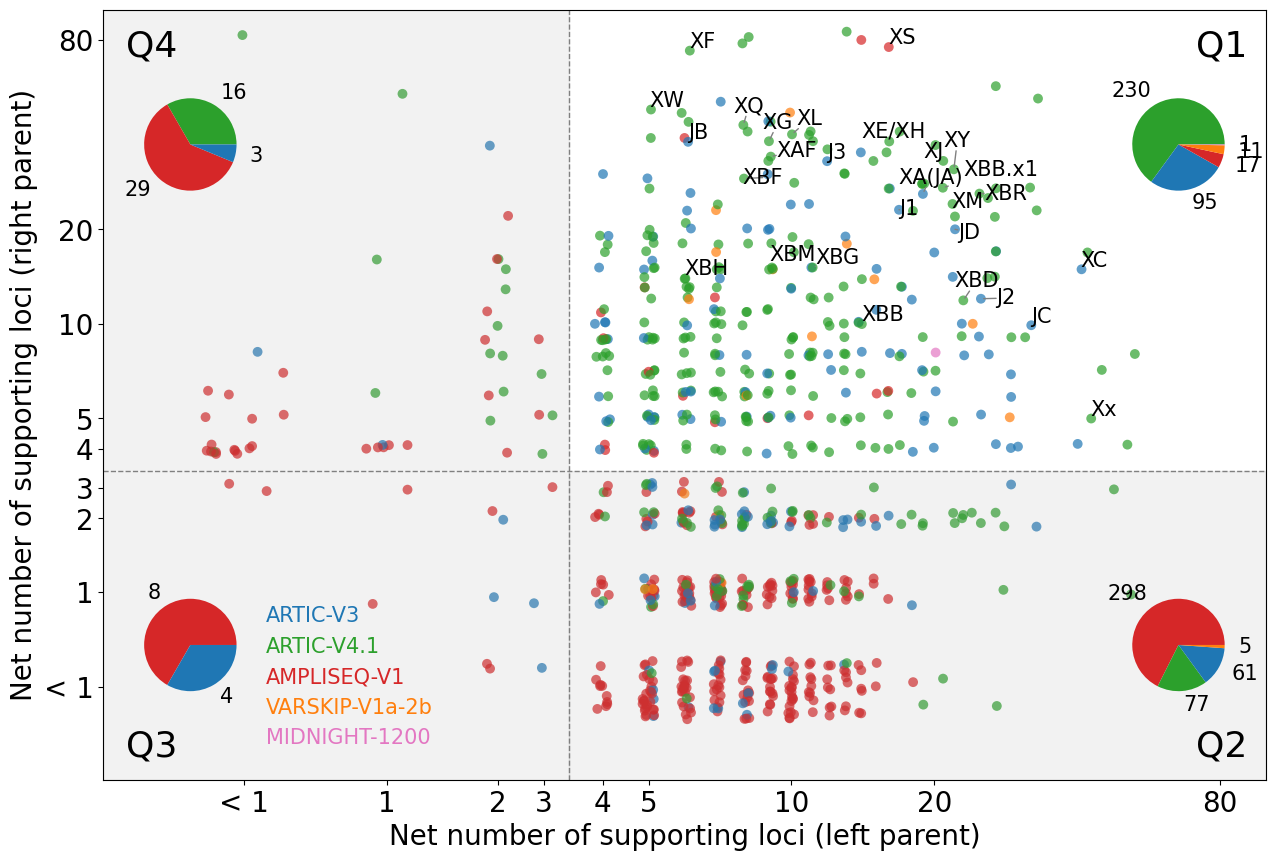

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import adjustText

# Set jittered coordinates.
j_width = 0.15
j1 = np.random.uniform(-j_width, j_width, len(recomb_df))
j2 = np.random.uniform(-j_width, j_width, len(recomb_df))

# Set custom coordinates for the cases <= 2.
m1_coord = 0.7
adj_coord = 0.4

a = recomb_df.net_min_supporting_loci_lft.copy().astype(float)
b = recomb_df.net_min_supporting_loci_rgt.copy().astype(float)
a[a <= 0] = m1_coord
b[b <= 0] = m1_coord
a[a == 1] = 1 + adj_coord
b[b == 1] = 1 + adj_coord
a[a == 2] = 2 + adj_coord
b[b == 2] = 2 + adj_coord
x = a + j1
y = b + j2


fontsize = 20

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

ax.tick_params(axis='both', which='major', labelsize=fontsize)
xticks = [m1_coord, 1 + adj_coord, 2 + adj_coord, 3, 4, 5, 10, 20, 80]
xtick_labels = ["< 1", "1", "2"] + [str(x) for x in xticks[3:]]
ax.set_xticks(ticks=np.log2(xticks), labels=xtick_labels, fontsize=fontsize)
yticks = [m1_coord, 1 + adj_coord, 2 + adj_coord, 3, 4, 5, 10, 20, 80]
ytick_labels = ["< 1", "1", "2"] + [str(y) for y in yticks[3:]]
ax.set_yticks(ticks=np.log2(yticks), labels=ytick_labels, fontsize=fontsize)

# Add text labels indicating the Pango X-associated recombination events.
texts = []
re_labels = nb_utils.standard_recombinant_labels(ts, events_file)
for (xx, yy, row) in zip(x, y, recomb_df.itertuples()):
    if row.recombinant in re_labels:
        texts.append(ax.text(x=np.log2(xx), y=np.log2(yy), s=re_labels[row.recombinant], fontsize=15))

ax.scatter(
    x=np.log2(x),
    y=np.log2(y),
    c=[colorpal[x] for x in recomb_df.Viridian_amplicon_scheme],
    s=50,
    alpha=0.7,
    linewidths=0,
)

adjustText.adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="gray", shrinkA=15, lw=1),
    ax=ax,
)

ax.axvline(np.log2(3 + adj_coord), linestyle="--", linewidth=1, color="gray")
ax.axhline(np.log2(3 + adj_coord), linestyle="--", linewidth=1, color="gray")
ax.set_xlim(-1.5, np.log2(100))
ax.set_ylim(-1.5, np.log2(100))
ax.set_xlabel('Net number of supporting loci (left parent)', fontsize=fontsize)
ax.set_ylabel('Net number of supporting loci (right parent)', fontsize=fontsize)

fx = np.array([-1.5, np.log2(3 + adj_coord)])
fy1 = np.array([np.log2(100), np.log2(100)])
fy2 = np.array([-1.5, -1.5])
ax.fill_between(fx, fy1, fy2, where=(fy1 > fy2), color="gray", alpha=0.1)

fx = np.array([np.log2(3 + adj_coord), np.log2(100)])
fy1 = np.array([np.log2(3 + adj_coord), np.log2(3 + adj_coord)])
fy2 = np.array([-1.5, -1.5])
ax.fill_between(fx, fy1, fy2, where=(fy1 > fy2), color="gray", alpha=0.1)

empty_patch = mpatches.Patch(color='none', label='')
ax.legend(
    labels=[x.replace("COVID-", "") for x in colorpal.keys()],
    labelcolor=colorpal.values(),
    handles=[empty_patch for _ in colorpal.keys()],
    bbox_to_anchor=(0.30, 0.25),
    fontsize=15,
    frameon=False,
)


# Add pie charts showing breakdown by amplicon scheme.
def plot_inset_pie(ax, wedge_sizes, labels, colors, labeldistance=1.3, fontsize=15):
    ax.pie(
        x=wedge_sizes,
        labels=labels,
        colors=colors,
        labeldistance=labeldistance,
        textprops={"fontsize": fontsize},
    )

inset_size = 0.15

ax.text(0.94, 0.94, "Q1", fontsize=26, transform=ax.transAxes)
ax_upper_right = ax.inset_axes([0.85, 0.75, inset_size, inset_size])
w = Counter(recomb_df.Viridian_amplicon_scheme[np.logical_and(a >= 4, b >= 4)])
plot_inset_pie(
    ax=ax_upper_right,
    wedge_sizes=w.values(),
    labels=[str(x) for x in w.values()],
    colors=[colorpal[x] for x in w.keys()],
)

ax.text(0.94, 0.03, "Q2", fontsize=26, transform=ax.transAxes)
ax_bottom_right = ax.inset_axes([0.85, 0.10, inset_size, inset_size])
w = Counter(recomb_df.Viridian_amplicon_scheme[np.logical_and(a >= 4, b < 4)])
plot_inset_pie(
    ax=ax_bottom_right,
    wedge_sizes=w.values(),
    labels=[str(x) for x in w.values()],
    colors=[colorpal[x] for x in w.keys()],
)

ax.text(0.02, 0.03, "Q3", fontsize=26, transform=ax.transAxes)
ax_bottom_left = ax.inset_axes([0.0, 0.10, inset_size, inset_size])
w = Counter(recomb_df.Viridian_amplicon_scheme[np.logical_and(a < 4, b < 4)])
plot_inset_pie(
    ax=ax_bottom_left,
    wedge_sizes=w.values(),
    labels=[str(x) for x in w.values()],
    colors=[colorpal[x] for x in w.keys()],
)

ax.text(0.02, 0.94, "Q4", fontsize=26, transform=ax.transAxes)
ax_upper_left = ax.inset_axes([0.0, 0.75, inset_size, inset_size])
w = Counter(recomb_df.Viridian_amplicon_scheme[np.logical_and(a < 4, b >= 4)])
plot_inset_pie(
    ax=ax_upper_left,
    wedge_sizes=w.values(),
    labels=[str(x) for x in w.values()],
    colors=[colorpal[x] for x in w.keys()],
)

plt.savefig("../figures/recombinant_qc.pdf", format='pdf');